In [1]:
from Dataset.dataset import FlchainSub1
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
import pickle
from model import SurvSHAP
import time
import pandas as pd
import matplotlib.pyplot as plt

import shap

# Load the Data

In [2]:
ds = FlchainSub1('Dataset/flchain.csv')

Dataset Description =======================
Dataset Name: flchain_sub1
Dataset Shape: (7874, 6)
Events: 27.55 %
NaN Values: 2.86 %
Events % in splits: 27.56, 27.56, 27.56, 27.56, 27.51, 



In [3]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print(x_train.shape)

(4724, 4)


# Train Survival Model (Random Survival Forest)

In [4]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape)

# train RSF
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=20,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           oob_score=True,
                           n_jobs=-1,
                           random_state=20)
rsf.fit(x_train, y_train_surv)

cindex_train = rsf.score(x_train, y_train_surv)
cindex_oob = rsf.oob_score_
cindex_val = rsf.score(x_val, y_val_surv)
cindex_test = rsf.score(x_test, y_test_surv)

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))
print('oob cindex {:.2f}'.format(cindex_oob*100))

(4724,)
Train cindex 85.82
Val cindex 79.09
Test cindex 76.79
oob cindex 78.91


# Prepare the Data and the Survival Curves for SurvSHAP

In [5]:
surv_train = rsf.predict_survival_function(x_train, return_array=True)
surv_val = rsf.predict_survival_function(x_val, return_array=True)
surv_test = rsf.predict_survival_function(x_test, return_array=True)

event_times=rsf.event_times_

#Prepare Data for Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

#Prepare the Survival Curves for Explanation
survival_curves = (surv_train, surv_val, surv_test)

# Explain

shape: 1151


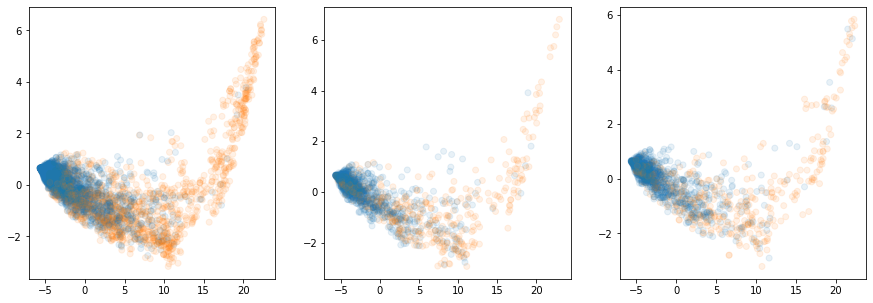

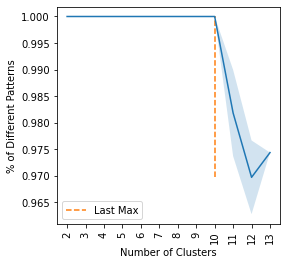

<Figure size 360x360 with 0 Axes>

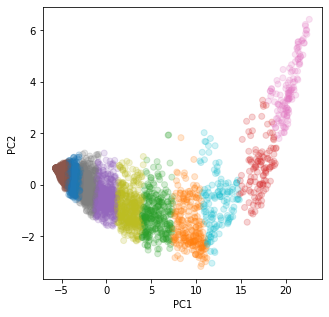

<Figure size 360x360 with 0 Axes>

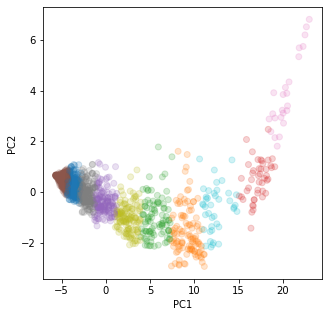

<Figure size 360x360 with 0 Axes>

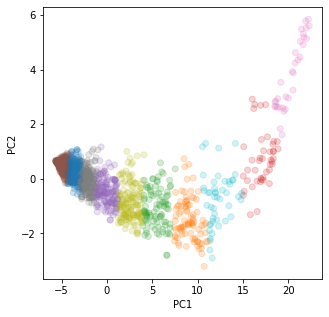

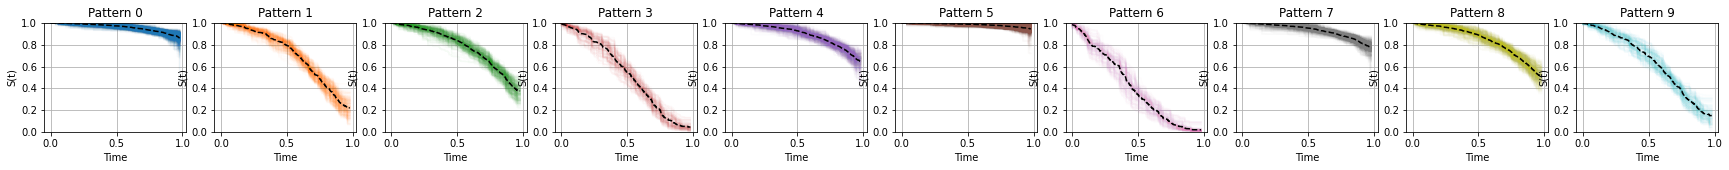

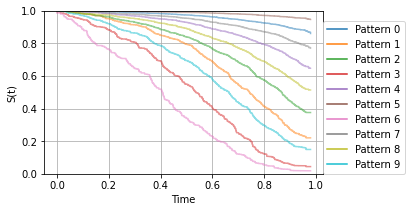

In [6]:
explainer = SurvSHAP(prefix_name='flchain_sub1_example', max_depth=15)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)

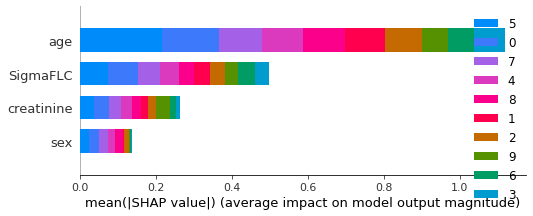

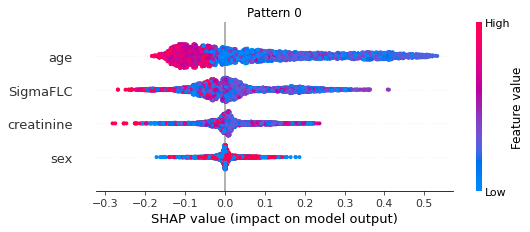

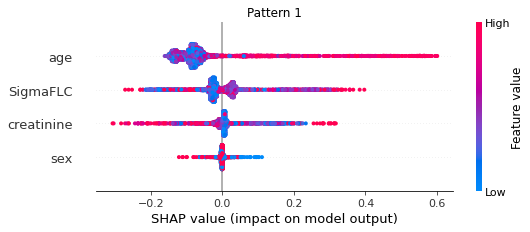

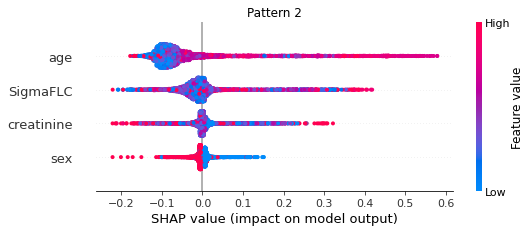

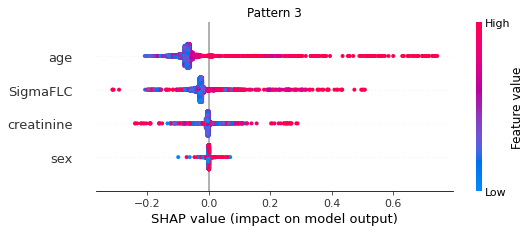

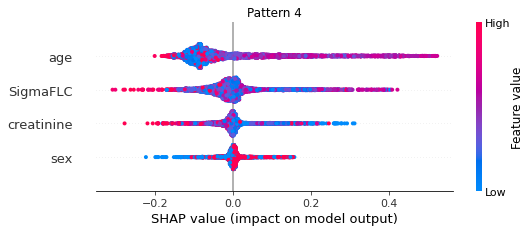

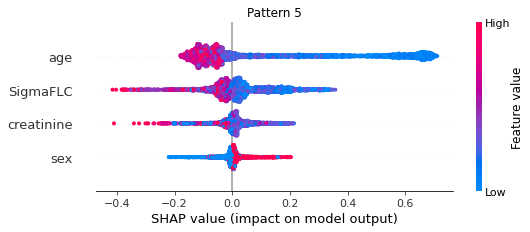

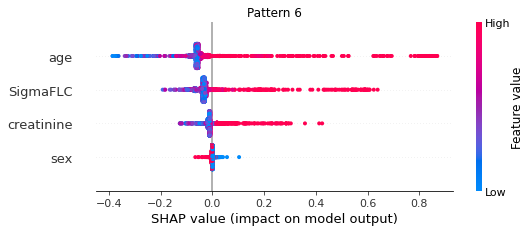

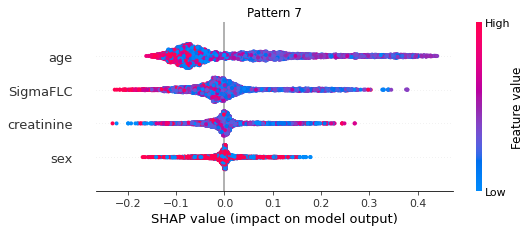

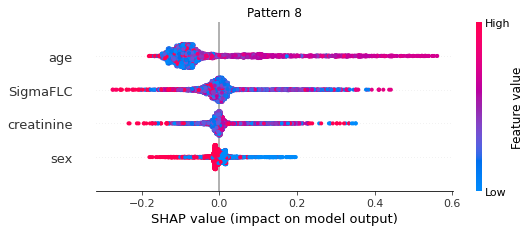

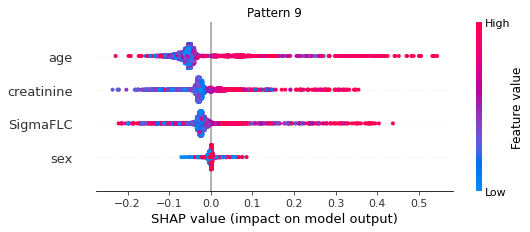

In [7]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

# Check Specific Pattern

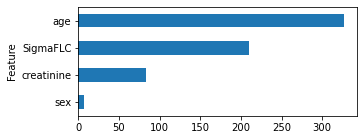

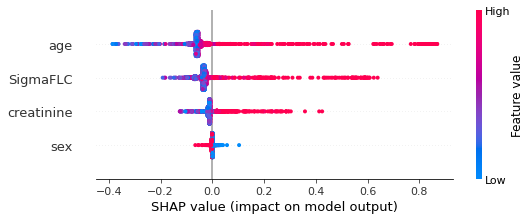

In [8]:
pattern = 6
feature_importnce_df = pd.DataFrame(zip(ds.features_names, np.abs(explainer.shap_values[pattern]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

plt.figure(figsize=(5, 2))
feature_importnce_df.sort_values('Importance')['Importance'].plot.barh()
plt.figure()
shap.summary_plot(explainer.shap_values[pattern], x_train, feature_names=ds.features_names, show=False)

In [15]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [16]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')